In [ ]:
from glob import glob
from tifffile import imwrite
from visualization_utils import plot_traces
from wfield import approximate_svd
from wfield import hemodynamic_correction
from wfield import reconstruct
from wfield.io import frames_average_for_trials, mmap_dat, TiffStack

import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd

In [20]:
root = '/home/wrx/Data_WF/WF_WRX'
mouse_id = 'H1'
date = '20250310'
date_folder = os.path.join(root, mouse_id, date)
treatment = 'DOM'
folder = os.path.join(date_folder, treatment)

In [21]:
dat = mmap_dat(glob(os.path.join(folder, '*uint16.bin'))[0])
print(dat.shape)
image_base_min = np.min(dat[-300:, :, :, :], axis=0)

(59117, 2, 460, 430)


In [ ]:
# save the first frame as a tiff file
tiff_file = os.path.join(folder, 'reference.tif')
imwrite(tiff_file, dat[0, :, :, :])

In [23]:
U, SVT = approximate_svd(dat, image_base_min)

Computing SVT from the raw data: 100%|██████████| 119/119 [11:58<00:00,  6.03s/it]


In [26]:
parameters_path = os.path.join(folder, 'parameters.npy')
parameters = np.load(parameters_path, allow_pickle=True).item()

In [29]:
U.shape, SVT.shape

((460, 430, 200), (200, 118234))

In [32]:
tstart = time.time()
fs = parameters['frame_rate']
freq_highpass = 0.001
SVT_470 = SVT[:,0::2]
t = np.arange(SVT.shape[1]) # interpolate the violet
from scipy.interpolate import interp1d
SVT_405 = interp1d(t[1::2], SVT[:,1::2], axis=1,
                    fill_value='extrapolate')(t[0::2])
SVTcorr, rcoeffs, T = hemodynamic_correction(U, SVT_470, SVT_405, fs=fs,
    freq_highpass=freq_highpass, freq_lowpass=10)  

print('Done hemodynamic correction in {0} s '.format(time.time()-tstart))
# SVTcorr = SVT_470 - SVT_405

Skipping lowpass on the violet channel.
Done hemodynamic correction in 151.03661060333252 s 


In [33]:
dat_re = reconstruct(U, SVTcorr)
print(dat_re.shape)

(59117, 460, 430)


In [34]:
F_corr = np.mean(dat_re, axis=(1,2))
# plot_traces(F_corr[:, np.newaxis], data_rate=10)

In [62]:
title = f'{mouse_id}_{date}_{treatment}'

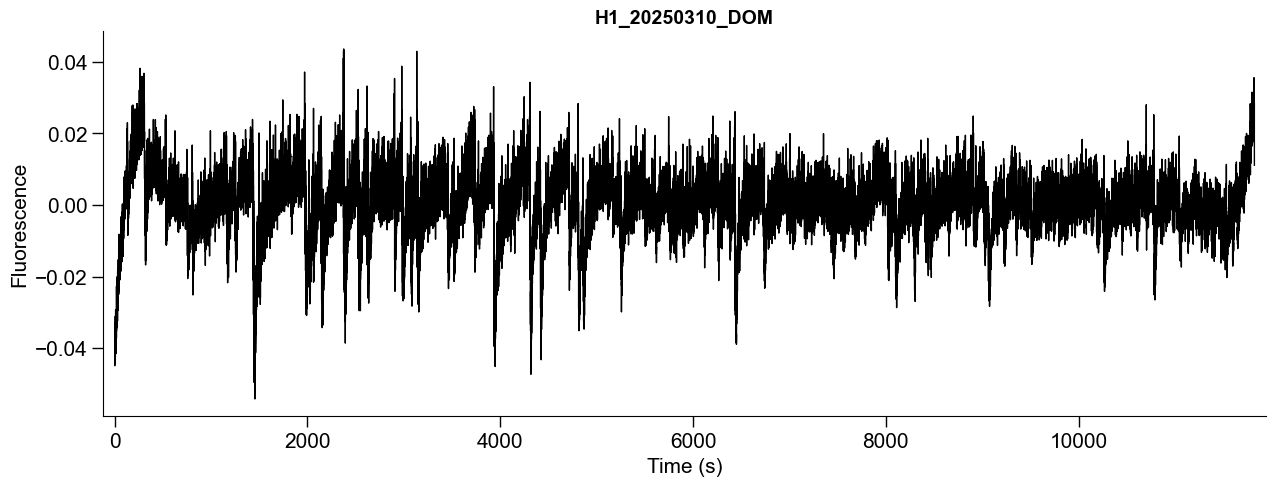

In [63]:

plot_traces(F_corr[:, np.newaxis], data_rate=parameters['frame_rate'],
    ylabel='Fluorescence', title=title)

In [64]:
csv_file = os.path.join(folder, 'results.csv')
if os.path.exists(csv_file):
    print('Reading existing csv file')
    df = pd.read_csv(csv_file)
else:
    print('The csv file does not exist')

Reading existing csv file


Calculate F_delta

In [ ]:
frame_mean_405 = df['frame_mean_405'].values
frame_mean_470 = df['frame_mean_470'].values
normalized_405 = frame_mean_405 / np.max(frame_mean_405)
normalized_470 = frame_mean_470 / np.max(frame_mean_470)
F_delta = (normalized_470 - normalized_405) / normalized_405

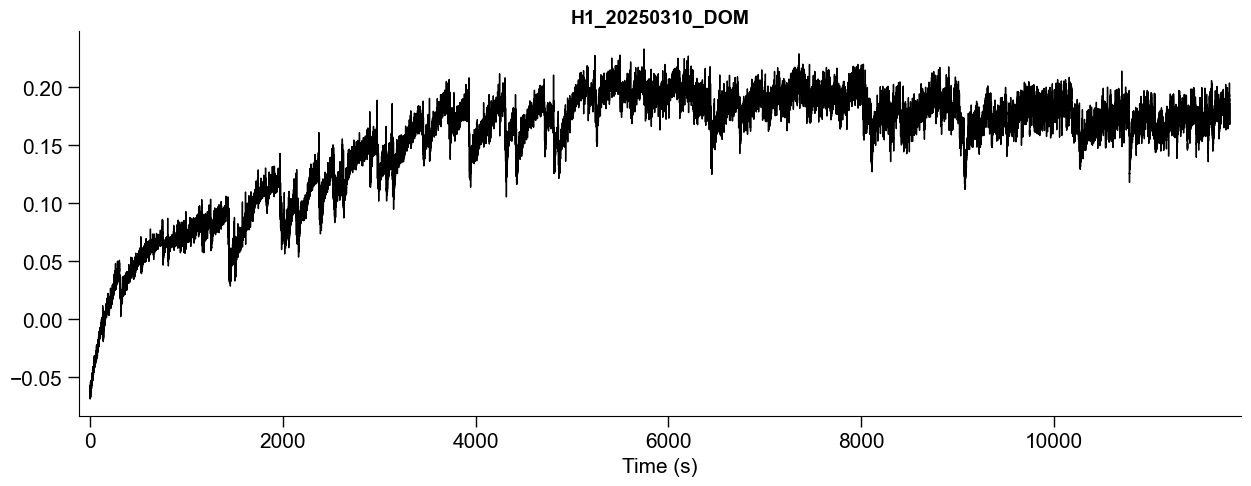

In [ ]:
plot_traces(F_delta[:, np.newaxis], data_rate=parameters['frame_rate'],
    title=title)

Save data to .csv file


In [69]:
df['F_corr'] = F_corr
df['F_delta'] = F_delta

df.to_csv(csv_file, index=False)
print('data saved to {}'.format(csv_file))

data saved to /home/wrx/Data_WF/WF_WRX/H1/20250310/DOM/results.csv
